In [1]:
import keras_tuner as kt

import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from keras.regularizers import L2, L1
from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
df_main = pd.read_csv('./Image_classification_data/data_labels_mainData.csv')

df_main['isCancerous_str'] = df_main['isCancerous'].apply(lambda x: 'No' if x == 0 else 'Yes' )
df_main['ImageName'] = df_main['ImageName'].astype('str')

train_data, test_data = train_test_split(df_main, test_size=0.15, random_state=7)
train_data, val_data = train_test_split(train_data, test_size=0.175, random_state=7)

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

BATCH_SIZE = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./Image_classification_data/patch_images/',
        x_col="ImageName",
        y_col="cellTypeName",
        target_size=(27, 27),
        batch_size=BATCH_SIZE,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./Image_classification_data/patch_images/',
        x_col="ImageName",
        y_col="cellTypeName",
        target_size=(27, 27),
        batch_size=BATCH_SIZE,
        class_mode='categorical')

Found 6939 validated image filenames belonging to 4 classes.
Found 1472 validated image filenames belonging to 4 classes.


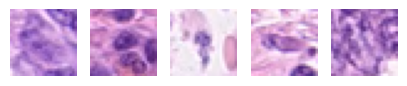

In [3]:
IMAGE_NO = 5
fig, axs = plt.subplots(1, IMAGE_NO, figsize=(IMAGE_NO, 3))
for i in range(IMAGE_NO):
    axs[i].axis('off')
    img, label = train_generator.next()
    axs[i].imshow(img[0])
plt.show()

In [4]:
cell_type_count = np.bincount(train_generator.classes)
total = np.sum(cell_type_count)
class_weight = {}
print(type(cell_type_count))
print(train_generator.class_indices)
for i, each_type_count in enumerate(cell_type_count):
    class_weight[i] = 1/each_type_count * total/len(cell_type_count)

print(f'Class Weight: {class_weight}')

<class 'numpy.ndarray'>
{'epithelial': 0, 'fibroblast': 1, 'inflammatory': 2, 'others': 3}
Class Weight: {0: 0.611904761904762, 1: 1.2708791208791208, 2: 0.9751264755480608, 3: 1.8070312499999999}


In [22]:
def model_builder(hp):
    model = keras.Sequential()

    model.add(tf.keras.layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=32), 
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]), 
        padding="same", 
        activation="relu", 
        input_shape=(27, 27, 3)))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(3,3)))

    model.add(tf.keras.layers.Conv2D(
        filters=hp.Int('conv_2_filter', min_value=32, max_value=128, step=32), 
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5]), 
        padding="same", 
        activation="relu",
        # kernel_regularizer=L2(hp.Choice('learning_rate_2', values=[1e-1, 1e-2, 1e-3, 1e-4]))
    ))
    
    model.add(tf.keras.layers.Conv2D(
        filters=hp.Int('conv_3_filter', min_value=32, max_value=128, step=32), 
        kernel_size=hp.Choice('conv_3_kernel', values = [3,5]), 
        padding="same", 
        activation="relu",
        # kernel_regularizer=L2(hp.Choice('learning_rate_3', values=[1e-1, 1e-2, 1e-3, 1e-4]))
    ))
    
    model.add(tf.keras.layers.Conv2D(
        filters=hp.Int('conv_4_filter', min_value=64, max_value=128, step=32), 
        kernel_size=hp.Choice('conv_4_kernel', values = [3,5]), 
        padding="same", 
        activation="relu",
        # kernel_regularizer=L2(hp.Choice('learning_rate_4', values=[1e-1, 1e-2, 1e-3, 1e-4]))
    ))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(3,3)))
    
    model.add(tf.keras.layers.Conv2D(
        filters=hp.Int('conv_5_filter', min_value=64, max_value=128, step=32), 
        kernel_size=hp.Choice('conv_5_kernel', values = [3,5]), 
        padding="same", 
        activation="relu",
        # kernel_regularizer=L2(hp.Choice('learning_rate_5', values=[1e-1, 1e-2, 1e-3, 1e-4]))
    ))
    model.add(tf.keras.layers.Conv2D(
        filters=hp.Int('conv_6_filter', min_value=64, max_value=128, step=32), 
        kernel_size=hp.Choice('conv_6_kernel', values = [3,5]), 
        padding="same", 
        activation="relu",
        # kernel_regularizer=L2(hp.Choice('learning_rate_6', values=[1e-1, 1e-2, 1e-3, 1e-4]))
    ))
    tf.keras.layers.MaxPooling2D(pool_size=(3,3)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=hp.Int('dense_1_unit', min_value=128, max_value=512, step=128), activation="relu"),
    tf.keras.layers.Dense(units=hp.Int('dense_2_unit', min_value=128, max_value=512, step=128), activation="relu"),
    
    model.add(keras.layers.Dense(4))

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    # hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 1e-4])),
                loss=keras.losses.CategoricalCrossentropy(),
                metrics=['accuracy'])

    return model

In [23]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=50,
                     factor=3,
                     directory='kt',
                     project_name='cell_type_tune_2')

INFO:tensorflow:Reloading Tuner from kt/cell_type_tune_2/tuner0.json


INFO:tensorflow:Reloading Tuner from kt/cell_type_tune_2/tuner0.json


In [15]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [17]:
train, labels = [], []

for i in range(5000):
    img, label = train_generator.next()
#     print(type(img))
    train.append(img)
    labels.append(np.argmax(label))

# train = np.array(train)
# labels = np.array(labels)
# print(train[0]) 

In [24]:
tuner.search(train, labels, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

# print(tuner.results_summary())


Search: Running Trial #10

Value             |Best Value So Far |Hyperparameter
64                |96                |conv_1_filter
3                 |5                 |conv_1_kernel
128               |96                |conv_2_filter
3                 |3                 |conv_2_kernel
0.001             |0.01              |learning_rate
32                |96                |conv_3_filter
3                 |5                 |conv_3_kernel
64                |64                |conv_4_filter
5                 |3                 |conv_4_kernel
128               |64                |conv_5_filter
3                 |3                 |conv_5_kernel
64                |64                |conv_6_filter
3                 |5                 |conv_6_kernel
256               |128               |dense_1_unit
256               |128               |dense_2_unit
0.01              |0.0001            |learning_rate_2
0.01              |0.1               |learning_rate_3
0.0001            |0.1           

Traceback (most recent call last):
  File "/Users/chello/opt/anaconda3/envs/cml-cpu/lib/python3.8/site-packages/keras_tuner/engine/base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/Users/chello/opt/anaconda3/envs/cml-cpu/lib/python3.8/site-packages/keras_tuner/engine/base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/Users/chello/opt/anaconda3/envs/cml-cpu/lib/python3.8/site-packages/keras_tuner/tuners/hyperband.py", line 425, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
  File "/Users/chello/opt/anaconda3/envs/cml-cpu/lib/python3.8/site-packages/keras_tuner/engine/tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/Users/chello/opt/anaconda3/envs/cml-cpu/lib/python3.8/site-packages/keras_tuner/engine/tuner.py", line 214, in _build_and_fit_model
    

RuntimeError: Number of consecutive failures excceeded the limit of 3.
Traceback (most recent call last):
  File "/Users/chello/opt/anaconda3/envs/cml-cpu/lib/python3.8/site-packages/keras_tuner/engine/base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/Users/chello/opt/anaconda3/envs/cml-cpu/lib/python3.8/site-packages/keras_tuner/engine/base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/Users/chello/opt/anaconda3/envs/cml-cpu/lib/python3.8/site-packages/keras_tuner/tuners/hyperband.py", line 425, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
  File "/Users/chello/opt/anaconda3/envs/cml-cpu/lib/python3.8/site-packages/keras_tuner/engine/tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/Users/chello/opt/anaconda3/envs/cml-cpu/lib/python3.8/site-packages/keras_tuner/engine/tuner.py", line 214, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "/Users/chello/opt/anaconda3/envs/cml-cpu/lib/python3.8/site-packages/keras_tuner/engine/hypermodel.py", line 144, in fit
    return model.fit(*args, **kwargs)
  File "/Users/chello/opt/anaconda3/envs/cml-cpu/lib/python3.8/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/Users/chello/opt/anaconda3/envs/cml-cpu/lib/python3.8/site-packages/keras/src/engine/data_adapter.py", line 1766, in train_validation_split
    raise ValueError(
ValueError: `validation_split` is only supported for Tensors or NumPy arrays, found following types in the input: [<class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>, <class 'numpy.int64'>]


In [ ]:
best_param = tuner.get_best_hyperparameters()[0]

print(best_param.values)